## Party starts

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import PIL 
import skimage
from kaggle_datasets import KaggleDatasets as kd
import tensorflow_addons as tfa
import re, os , random
import tensorflow.keras.backend as K
import tensorflow.keras.losses as losses


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

In [3]:
GCS_PATH= kd().get_gcs_path('gan-getting-started')
monet_files=tf.io.gfile.glob(str(GCS_PATH+'/monet_tfrec/monet*.tfrec'))
photo_files=tf.io.gfile.glob(GCS_PATH+'/photo_tfrec/photo*.tfrec')

def count(filenames):
    n=[int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return (np.sum(n))
    
n_monet_samples, n_photo_samples=count(monet_files), count(photo_files)
print("MONET FILES = ",count(monet_files))
print("PHOTO FILES = ",count(photo_files))


MONET FILES =  300
PHOTO FILES =  7038


## Pipeline

In [4]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 100
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

In [5]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
        
    
    return image


In [6]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

check the pipeline

In [7]:
def display_samples(ds, row=8,columns=4,bs=32):
#     batch = next(iter(ds))
    fig,ax=plt.subplots(row,columns,figsize=(20,20))
    k=0
    for i in range(row) :
        for j in range(columns):
            if k>bs-1:
                break
            ax[i,j].imshow(next(iter(ds))[0])
            ax[i,j].axis('off')
            k+=1
            

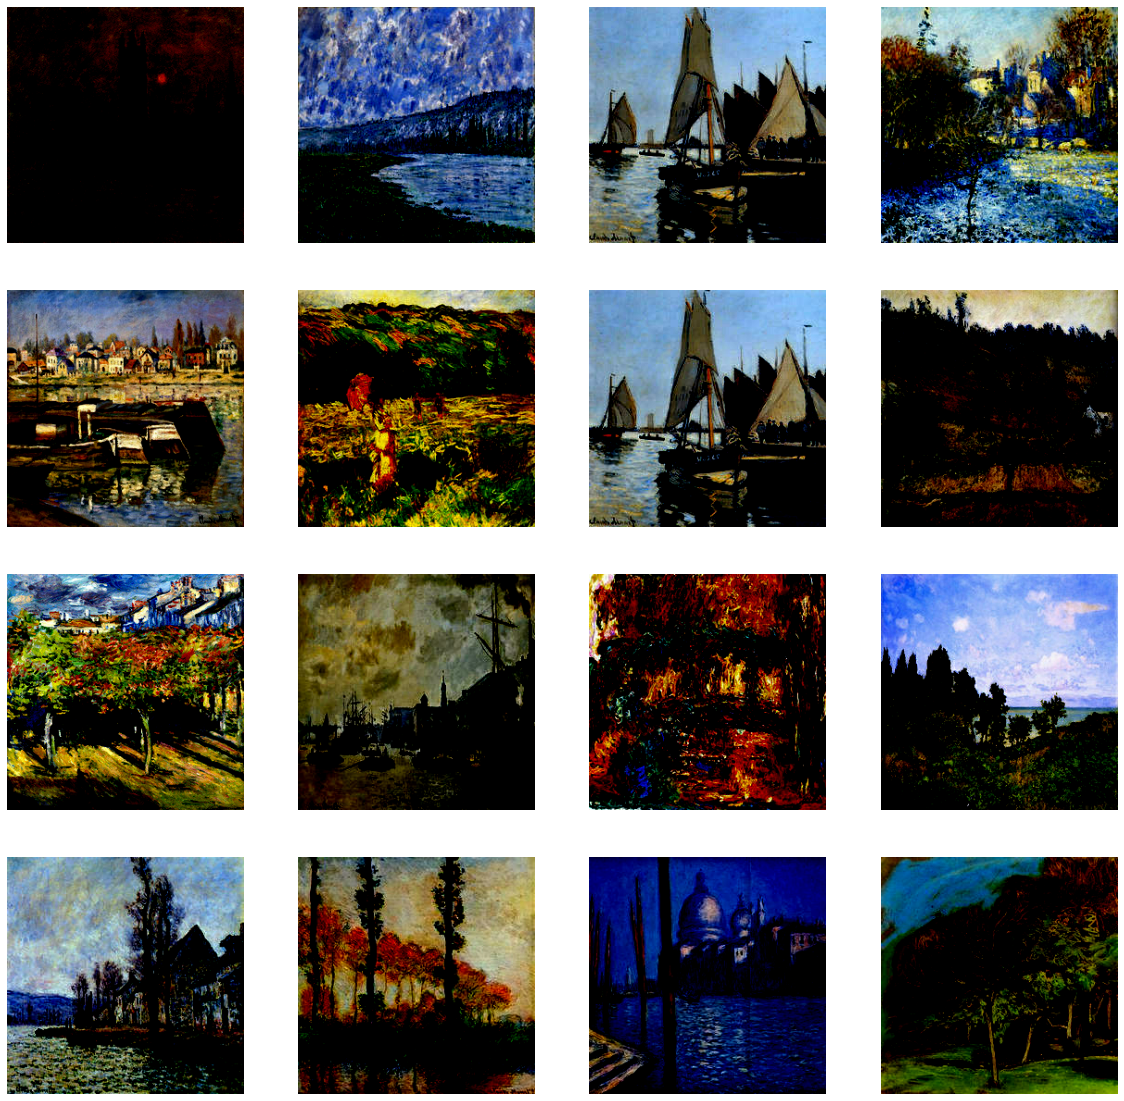

In [8]:
ds=get_dataset(monet_files)
display_samples(ds,4,4,16)



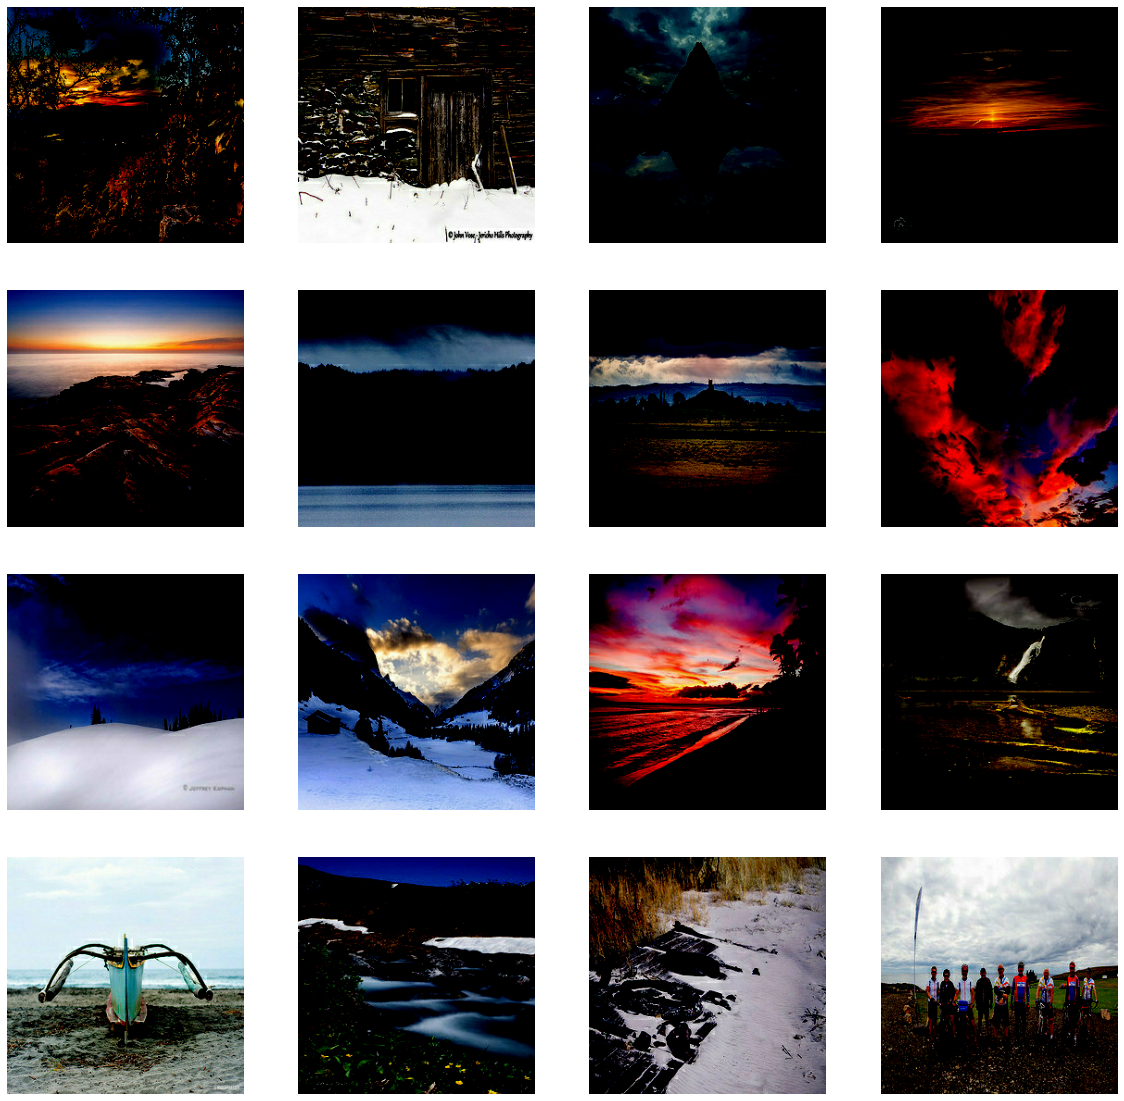

In [9]:
ds=get_dataset(photo_files)
display_samples(ds,4,4,16)

## Model

In [10]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=tf.keras.layers.ReLU(), name='block_x'):
    block = tf.keras.layers.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = tf.keras.layers.ReLU()(block)
    
    block = tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = tf.keras.layers.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = tf.keras.layers.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = tf.keras.layers.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    

    block = tf.keras.layers.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = tf.keras.layers.ReLU()(block)
    
    return block

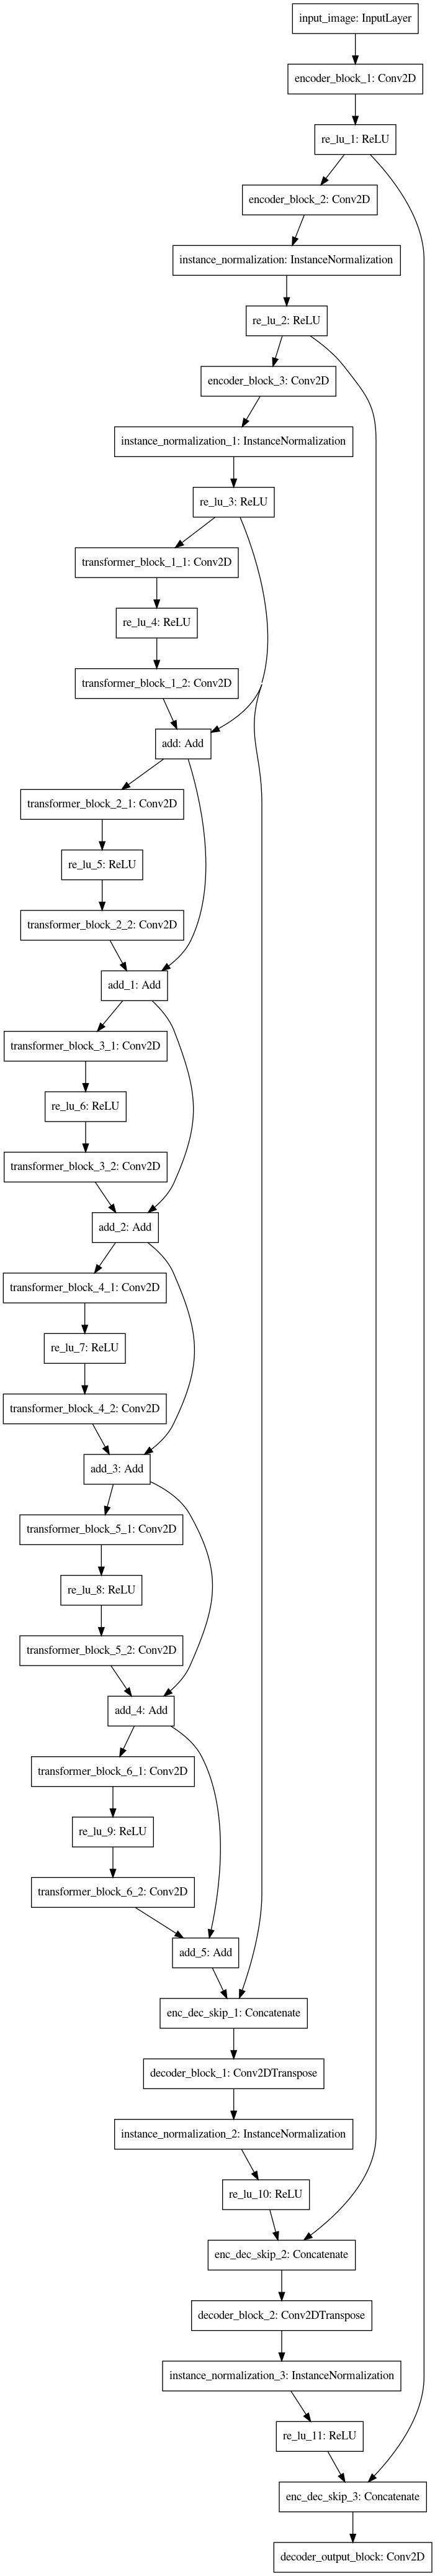

In [11]:
## Generator
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = tf.keras.layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=tf.keras.layers.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=tf.keras.layers.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=tf.keras.layers.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = tf.keras.layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = tf.keras.layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = tf.keras.layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = tf.keras.Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
tf.keras.utils.plot_model(sample_generator)

17227776/17225924 [==============================] - 0s 0us/step


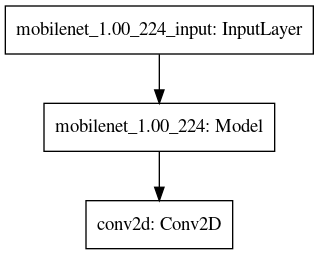

In [12]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = tf.keras.layers.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder
    # Pre-trained model
    base_model = tf.keras.applications.MobileNet(include_top=False,
                                                 input_tensor=inputs)
    base_model.trainable = False # Freeze layers
    

    
    discriminator = tf.keras.Sequential([
                        base_model,
                        tf.keras.layers.Conv2D(1, 1, strides=1, padding='valid', kernel_initializer=conv_initializer)
                    ])

    return discriminator


sample_discriminator = discriminator_fn()
tf.keras.utils.plot_model(sample_discriminator)


In [13]:
with strategy.scope():
    monet_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE) # differentiates real photos and generated photos


class CycleGan(tf.keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

## loss

In [14]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

In [15]:
@tf.function
def linear_schedule_with_warmup(step):
    
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.

    steps_per_epoch = int(max(count(monet_files), count(photo_files))//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8

    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr




In [16]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(7038//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr


## train

In [17]:
with strategy.scope():
    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

# Create dataset
monet_ds = get_dataset(monet_files, augment=True, batch_size=BATCH_SIZE)
photo_ds = get_dataset(photo_files, augment=True, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

photo_ds_eval = get_dataset(photo_files,repeat=False,  
                            shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(monet_files,repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generated_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generated_{i}_{epoch+1}.png')



In [18]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS, 
                        callbacks=[GANMonitor()], 
                        steps_per_epoch=(max(count(monet_files), count(photo_files))//BATCH_SIZE), 
                        verbose=1).history

Epoch 1/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 3.8024 - photo_disc_loss: 0.5124 - photo_gen_loss: 3.9378 - monet_disc_loss: 0.6077
Epoch 2/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 3.1203 - photo_disc_loss: 0.5278 - photo_gen_loss: 3.4251 - monet_disc_loss: 0.6408
Epoch 3/100
439/439 [==============================] - 46s 106ms/step - monet_gen_loss: 2.9036 - photo_disc_loss: 0.5189 - photo_gen_loss: 3.2248 - monet_disc_loss: 0.6323
Epoch 4/100
439/439 [==============================] - 46s 106ms/step - monet_gen_loss: 2.7926 - photo_disc_loss: 0.5263 - photo_gen_loss: 3.1216 - monet_disc_loss: 0.6293
Epoch 5/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 2.7023 - photo_disc_loss: 0.5237 - photo_gen_loss: 3.0055 - monet_disc_loss: 0.6278
Epoch 6/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 2.6380 - photo_disc_loss: 0.5319 - photo_gen_loss: 2

439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 1.9462 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.2159 - monet_disc_loss: 0.6665
Epoch 49/100
439/439 [==============================] - 46s 106ms/step - monet_gen_loss: 1.9582 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.2216 - monet_disc_loss: 0.6701
Epoch 50/100
439/439 [==============================] - 46s 106ms/step - monet_gen_loss: 1.9479 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.1861 - monet_disc_loss: 0.6580
Epoch 51/100
439/439 [==============================] - 47s 106ms/step - monet_gen_loss: 1.9408 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.2042 - monet_disc_loss: 0.6674
Epoch 52/100
439/439 [==============================] - 47s 106ms/step - monet_gen_loss: 1.9480 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.2002 - monet_disc_loss: 0.6660
Epoch 53/100
439/439 [==============================] - 47s 107ms/step - monet_gen_loss: 1.9130 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.1671 -

439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 1.5804 - photo_disc_loss: 0.6481 - photo_gen_loss: 1.6897 - monet_disc_loss: 0.6758
Epoch 95/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 1.5711 - photo_disc_loss: 0.6673 - photo_gen_loss: 1.6707 - monet_disc_loss: 0.6764
Epoch 96/100
439/439 [==============================] - 47s 107ms/step - monet_gen_loss: 1.5585 - photo_disc_loss: 0.6605 - photo_gen_loss: 1.6626 - monet_disc_loss: 0.6747
Epoch 97/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 1.5392 - photo_disc_loss: 0.6455 - photo_gen_loss: 1.6504 - monet_disc_loss: 0.6781
Epoch 98/100
439/439 [==============================] - 47s 106ms/step - monet_gen_loss: 1.5270 - photo_disc_loss: 0.6591 - photo_gen_loss: 1.6250 - monet_disc_loss: 0.6806
Epoch 99/100
439/439 [==============================] - 46s 105ms/step - monet_gen_loss: 1.5454 - photo_disc_loss: 0.6557 - photo_gen_loss: 1.6374 -

# **Save models and visualise results**

In [21]:
monet_generator.save('monet_generator.h5')
photo_generator.save('photo_generator.h5')
monet_discriminator.save('monet_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')

In [19]:
# save GIF
import imageio
import os
images = []
filenames=os.listdir('./monet')
for filename in filenames:
    b_path='./monet/'
    images.append(imageio.imread(b_path+filename))
imageio.mimsave('monet.gif', images)
filenames=os.listdir('./photo')
for filename in filenames:
    b_path='./photo/'
    images.append(imageio.imread(b_path+filename))
imageio.mimsave('photo.gif', images)

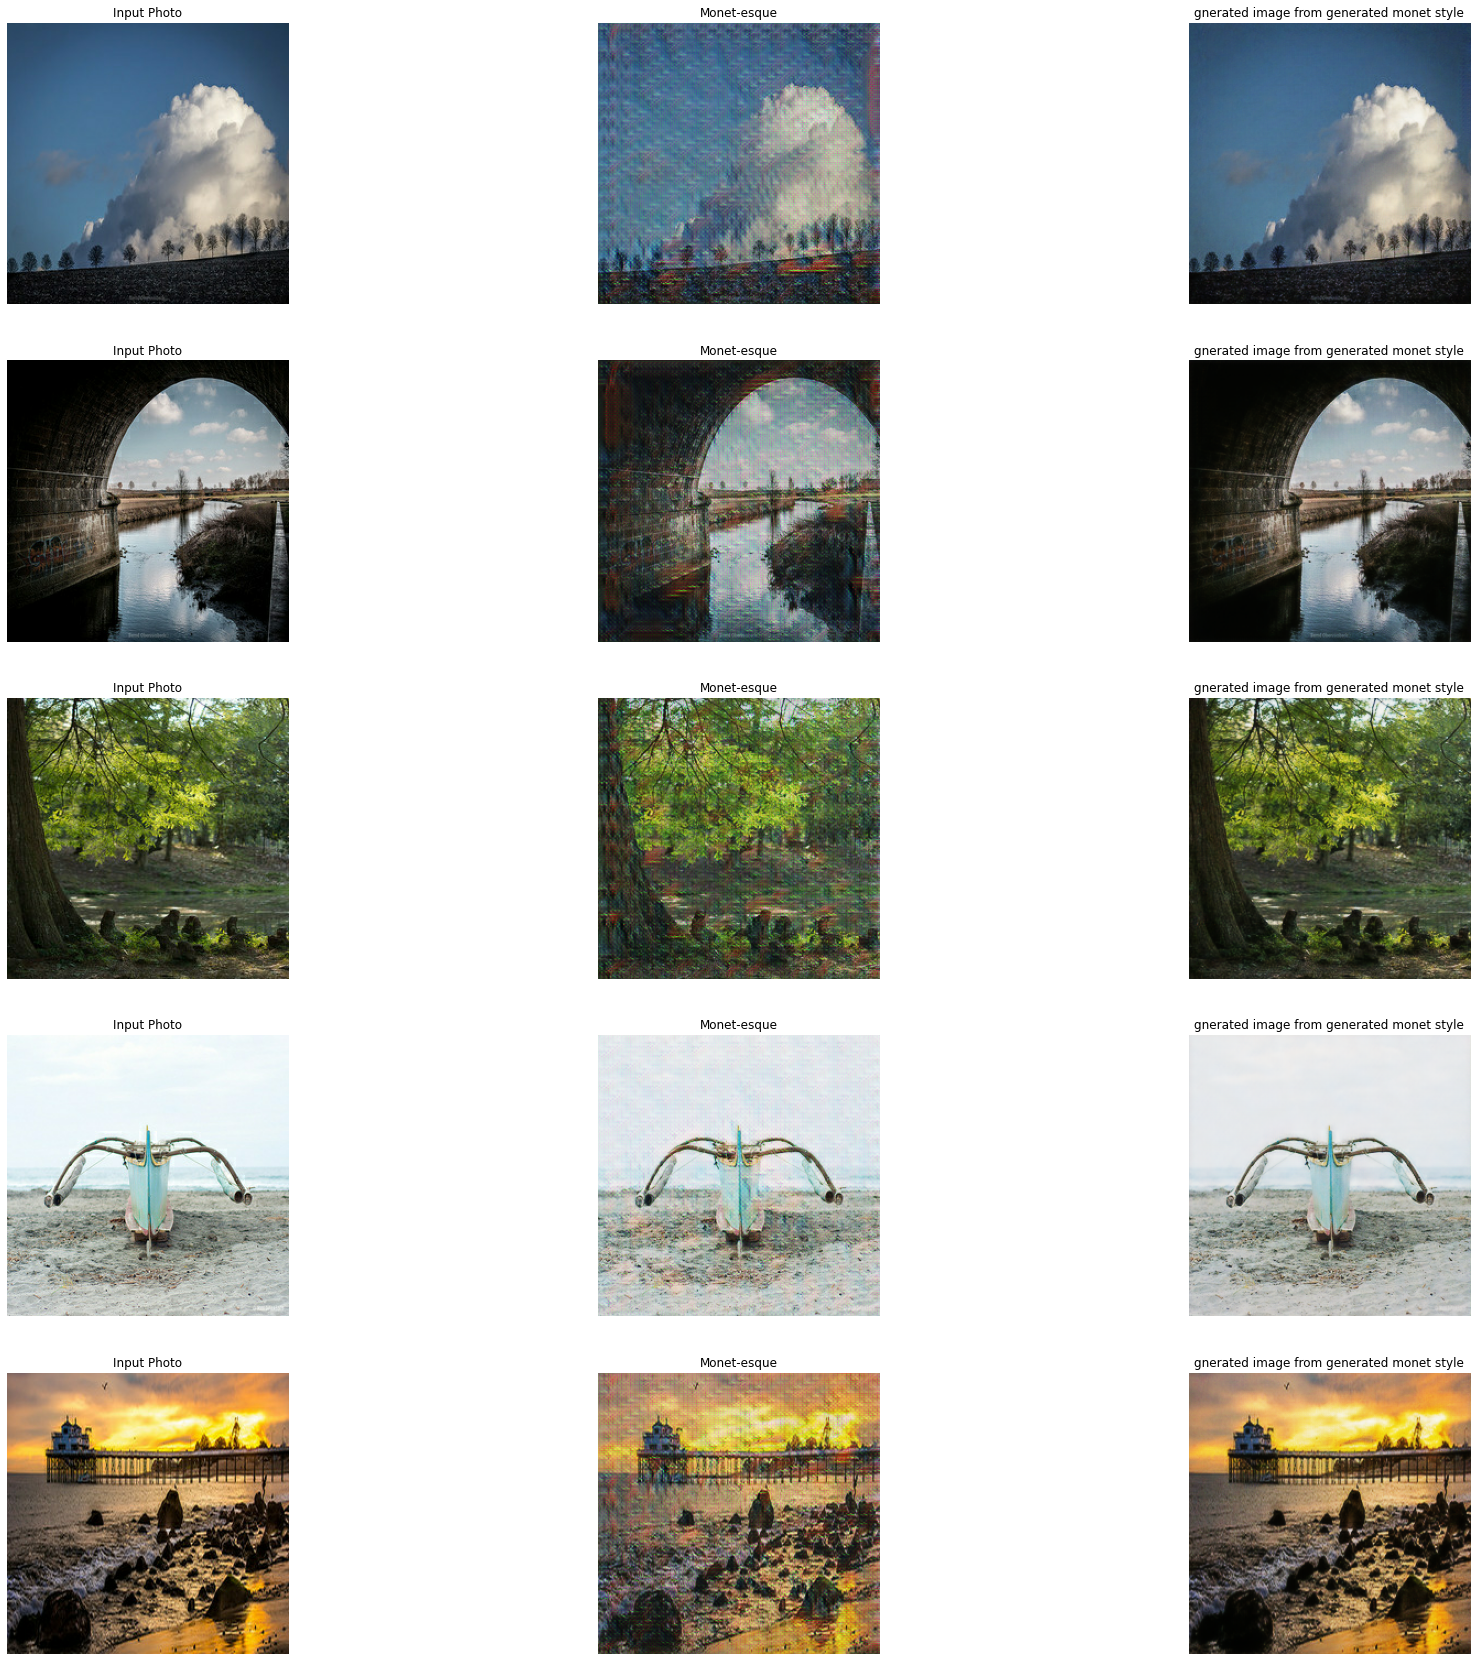

In [40]:
_, ax = plt.subplots(5, 3, figsize=(30, 30))
for i, img in enumerate(photo_ds_eval.take(5)):
    prediction1 = monet_generator(img, training=False).numpy()
    prediction = (prediction1[0] * 127.5 + 127.5).astype(np.uint8)
    pic_gen = photo_generator(prediction1, training=False).numpy()
    pic_gen = (pic_gen[0] * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(pic_gen)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 2].set_title('gnerated image from generated monet style')
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()

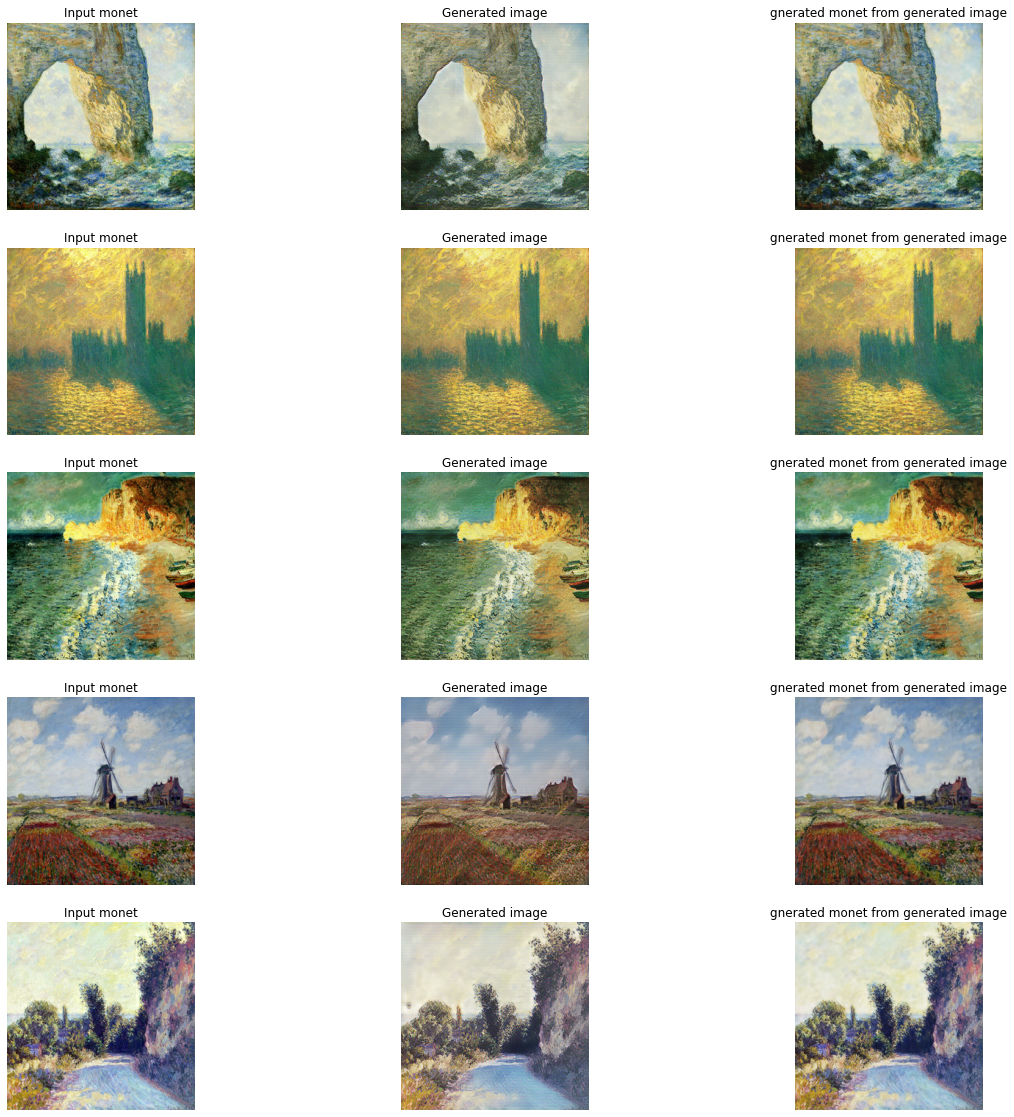

In [43]:
_, ax = plt.subplots(5, 3, figsize=(20, 20))
for i, img in enumerate(monet_ds_eval.take(5)):
    
    prediction1 = photo_generator(img, training=False).numpy()
    prediction = (prediction1[0] * 127.5 + 127.5).astype(np.uint8)
    pic_gen = monet_generator(prediction1, training=False).numpy()
    pic_gen = (pic_gen[0] * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 2].imshow(pic_gen)
    ax[i, 0].set_title("Input monet")
    ax[i, 1].set_title("Generated image")
    ax[i, 2].set_title('gnerated monet from generated image')
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")
plt.show()